In [1]:
# conda install keras-tuner
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import seaborn as sns
sns.set()
from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
# import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras import losses
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import *
import keras_tuner as kt

2022-12-04 00:37:01.201390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### ltc

In [3]:
regs = pd.read_csv("../Data/train_ltc_selected_features.csv")
ltc = pd.read_csv("../Data/litecoin_Data.csv")
for i in range(len(ltc['Date'])):
    ltc['Date'][i]  =  datetime.strptime(ltc['Date'][i], '%Y/%m/%d')

ltc = ltc.set_index("Date")

/tmp/ipykernel_1732882/1097672958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltc['Date'][i]  =  datetime.strptime(ltc['Date'][i], '%Y/%m/%d')


In [4]:
ltcData = ltc[regs.columns]

In [5]:
ltcData['returns'] = ltcData['priceUSD'].pct_change()

/tmp/ipykernel_1732882/1118086751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltcData['returns'] = ltcData['priceUSD'].pct_change()


In [6]:
Data = ltcData.drop(columns=['priceUSD'])
Data = Data[1:]

In [7]:
Data 

,activeaddresses30std,activeaddresses30var,activeaddresses7trx,difficulty,difficulty30mom,difficulty30trx,difficulty90mom,difficulty90roc,difficulty90rsi,difficulty90trx,...,sentinusd30emaUSD,sentinusd30smaUSD,sentinusd30wmaUSD,sentinusd90emaUSD,sentinusd90varUSD,sentinusd90wmaUSD,sentinusdUSD,top100cap,transactionvalueUSD,returns
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,7666,14691594,0.296,51718,2875.000,0.146,3694.0,7.693,55.143,0.073,...,13119990,14447549,13084361,15062343,9.207781e+13,15267519,6145265,49.907,1299.0,-0.004836
2016-01-03,7553,14263642,0.531,50653,1810.000,0.152,2764.0,5.771,53.920,0.074,...,12661408,14247155,12540130,14863434,9.237091e+13,15058214,6011974,49.914,1650.0,-0.008005
2016-01-04,6990,12215979,0.492,50158,1315.000,0.156,2268.0,4.737,53.364,0.074,...,12160118,13934412,11936534,14644269,9.336173e+13,14824650,4891418,49.963,1112.0,0.004323
2016-01-05,7207,12983796,-0.176,50158,436.688,0.159,1731.0,3.574,53.364,0.075,...,11733962,13588124,11395907,14444498,9.368327e+13,14607077,5554693,49.976,1505.0,-0.004878
2016-01-06,7368,13572232,-0.950,51299,1184.000,0.161,1473.0,2.956,54.471,0.075,...,11652530,13295257,11194853,14357186,9.312956e+13,14497960,10471777,49.916,3469.0,-0.004902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,55298,764459612,-0.329,19352505,2570167.000,0.274,3935133.0,25.524,61.809,0.095,...,1038289555,1236990379,1125469305,906646434,7.982758e+17,1088633253,361588723,44.670,30828.0,-0.001286
2022-11-25,55854,779921846,-0.097,19996996,3214659.000,0.279,4316584.0,27.529,63.623,0.097,...,990339490,1228280282,1064699832,893205052,7.936632e+17,1076450910,295063546,44.667,37548.0,-0.023929
2022-11-26,55376,766634614,-0.101,19996996,3214659.000,0.284,4316584.0,27.529,63.623,0.099,...,939695376,1214390963,998704699,878087484,7.902356e+17,1062224912,205355717,44.746,35847.0,0.012488


In [8]:
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = ltcData['priceUSD'].shift(-30)[1:] # 反之亦然

In [9]:
X.head(3)

,activeaddresses30std,activeaddresses30var,activeaddresses7trx,difficulty,difficulty30mom,difficulty30trx,difficulty90mom,difficulty90roc,difficulty90rsi,difficulty90trx,...,sentinusd30emaUSD,sentinusd30smaUSD,sentinusd30wmaUSD,sentinusd90emaUSD,sentinusd90varUSD,sentinusd90wmaUSD,sentinusdUSD,top100cap,transactionvalueUSD,returns
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,7666,14691594,0.296,51718,2875.0,0.146,3694.0,7.693,55.143,0.073,...,13119990,14447549,13084361,15062343,9.207781e+13,15267519,6145265,49.907,1299.0,-0.004836
2016-01-03,7553,14263642,0.531,50653,1810.0,0.152,2764.0,5.771,53.920,0.074,...,12661408,14247155,12540130,14863434,9.237091e+13,15058214,6011974,49.914,1650.0,-0.008005
2016-01-04,6990,12215979,0.492,50158,1315.0,0.156,2268.0,4.737,53.364,0.074,...,12160118,13934412,11936534,14644269,9.336173e+13,14824650,4891418,49.963,1112.0,0.004323


In [10]:
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

In [11]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


Pipeline(steps=[('mixmax', MinMaxScaler()), ['robust', RobustScaler()]],
         verbose=True)

In [12]:
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

In [13]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [14]:
# define neural network model
shape=X.shape[1]
def build_model(hp, initializer='normal', activation='relu', NUM_FEATURES=shape):
    # create model
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    model = Sequential()
    model.add(Dense(hp_units1, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(hp_units2, activation=activation))
    model.add(Dense(hp_units3, activation=activation))
    model.add(Dense(1, activation=activation))
    # Compile model
    adam=keras.optimizers.Adam(lr=lr_schedule(0), amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='logcosh', optimizer=adam, metrics=['mae'])
    return model

In [15]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    directory='ltc_tune',
    project_name='ANN_TUNE'
)

tuner.search(X_train, Y_train, epochs=5000, validation_data=(X_val, Y_val))

Trial 10 Complete [00h 32m 22s]
val_mae: 41.606048583984375

Best val_mae So Far: 36.382362365722656
Total elapsed time: 04h 36m 46s
INFO:tensorflow:Oracle triggered exit


In [16]:
# Get the best hyperparameters.
best_hp = tuner.get_best_hyperparameters()[0]
# Build the model with the best hp.
regressor = build_model(best_hp)
# Fit with the entire dataset.
X_all = np.concatenate((X_train, X_val))
Y_all = np.concatenate((Y_train, Y_val))


Learning rate:  0.001


In [17]:
# best hyperparameters
best_hp

stop training when loss is not increasing

In [18]:
earlyStopping = EarlyStopping(monitor='loss', patience=1000,verbose=1, mode='auto')

In [19]:
regressor.fit(x=X_all, y=Y_all, epochs=5000, use_multiprocessing=True, callbacks=[earlyStopping])
# regressor=KerasRegressor(build_fn=sequential_model,epochs=5000,verbose=1, use_multiprocessing=True, callback=[earlyStopping])

Epoch 1/5000
62/62 [==============================] - 0s 2ms/step - loss: 42.7254 - mae: 43.3891
Epoch 2/5000
62/62 [==============================] - 0s 2ms/step - loss: 18.3058 - mae: 18.9262
Epoch 3/5000
62/62 [==============================] - 0s 2ms/step - loss: 15.7504 - mae: 16.3637
Epoch 4/5000
62/62 [==============================] - 0s 2ms/step - loss: 14.7571 - mae: 15.3742
Epoch 5/5000
62/62 [==============================] - 0s 2ms/step - loss: 13.9100 - mae: 14.5325
Epoch 6/5000
62/62 [==============================] - 0s 2ms/step - loss: 12.5874 - mae: 13.1943
Epoch 7/5000
62/62 [==============================] - 0s 3ms/step - loss: 11.7270 - mae: 12.3353
Epoch 8/5000
62/62 [==============================] - 0s 3ms/step - loss: 10.1918 - mae: 10.7942
Epoch 9/5000
62/62 [==============================] - 0s 2ms/step - loss: 9.7973 - mae: 10.3917
Epoch 10/5000
62/62 [==============================] - 0s 3ms/step - loss: 9.2009 - mae: 9.7969
Epoch 11/5000
62/62 [===========

62/62 [==============================] - 0s 2ms/step - loss: 3.1917 - mae: 3.7069
Epoch 87/5000
62/62 [==============================] - 0s 2ms/step - loss: 3.2654 - mae: 3.7812
Epoch 88/5000
62/62 [==============================] - 0s 2ms/step - loss: 3.0672 - mae: 3.5743
Epoch 89/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.8876 - mae: 3.3847
Epoch 90/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.9471 - mae: 3.4577
Epoch 91/5000
62/62 [==============================] - 0s 3ms/step - loss: 3.1104 - mae: 3.6309
Epoch 92/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.9682 - mae: 3.4740
Epoch 93/5000
62/62 [==============================] - 0s 4ms/step - loss: 2.7963 - mae: 3.3147
Epoch 94/5000
62/62 [==============================] - 0s 5ms/step - loss: 3.4241 - mae: 3.9394
Epoch 95/5000
62/62 [==============================] - 0s 4ms/step - loss: 3.1368 - mae: 3.6442
Epoch 96/5000
62/62 [==============================] -

62/62 [==============================] - 0s 2ms/step - loss: 2.2170 - mae: 2.6998
Epoch 171/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.4105 - mae: 2.9056
Epoch 172/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.3250 - mae: 2.8153
Epoch 173/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.1068 - mae: 2.5850
Epoch 174/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.3495 - mae: 2.8278
Epoch 175/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.1900 - mae: 2.6727
Epoch 176/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.1762 - mae: 2.6578
Epoch 177/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.1760 - mae: 2.6607
Epoch 178/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.4952 - mae: 2.9919
Epoch 179/5000
62/62 [==============================] - 0s 2ms/step - loss: 2.2952 - mae: 2.7759
Epoch 180/5000
62/62 [=======================

62/62 [==============================] - 0s 2ms/step - loss: 1.9629 - mae: 2.4310
Epoch 255/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.7339 - mae: 2.1969
Epoch 256/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.6984 - mae: 2.1558
Epoch 257/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.8629 - mae: 2.3314
Epoch 258/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.7531 - mae: 2.2130
Epoch 259/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.7890 - mae: 2.2496
Epoch 260/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.6939 - mae: 2.1527
Epoch 261/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.7089 - mae: 2.1542
Epoch 262/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.8083 - mae: 2.2705
Epoch 263/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.9111 - mae: 2.3736
Epoch 264/5000
62/62 [=======================

62/62 [==============================] - 0s 2ms/step - loss: 1.4423 - mae: 1.8732
Epoch 339/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.5952 - mae: 2.0469
Epoch 340/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.6584 - mae: 2.1102
Epoch 341/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.5558 - mae: 1.9908
Epoch 342/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.4370 - mae: 1.8838
Epoch 343/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.6087 - mae: 2.0579
Epoch 344/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.7298 - mae: 2.1952
Epoch 345/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.7199 - mae: 2.1796
Epoch 346/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.5320 - mae: 1.9795
Epoch 347/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.5005 - mae: 1.9364
Epoch 348/5000
62/62 [=======================

62/62 [==============================] - 0s 2ms/step - loss: 1.4473 - mae: 1.8952
Epoch 423/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.2646 - mae: 1.7002
Epoch 424/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.2841 - mae: 1.7131
Epoch 425/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.2046 - mae: 1.6124
Epoch 426/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.1799 - mae: 1.5944
Epoch 427/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.2108 - mae: 1.6337
Epoch 428/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.2553 - mae: 1.6845
Epoch 429/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.3230 - mae: 1.7467
Epoch 430/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.3029 - mae: 1.7243
Epoch 431/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.1859 - mae: 1.6222
Epoch 432/5000
62/62 [=======================

62/62 [==============================] - 0s 2ms/step - loss: 1.5078 - mae: 1.9541
Epoch 507/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.0790 - mae: 1.4885
Epoch 508/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.1773 - mae: 1.5875
Epoch 509/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.0567 - mae: 1.4605
Epoch 510/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.1564 - mae: 1.5664
Epoch 511/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.1350 - mae: 1.5581
Epoch 512/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.2318 - mae: 1.6609
Epoch 513/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.2102 - mae: 1.6237
Epoch 514/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.1916 - mae: 1.6081
Epoch 515/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.3154 - mae: 1.7489
Epoch 516/5000
62/62 [=======================

62/62 [==============================] - 0s 2ms/step - loss: 1.0230 - mae: 1.4205
Epoch 591/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.9679 - mae: 1.3546
Epoch 592/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.4195 - mae: 1.8584
Epoch 593/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.9478 - mae: 1.3472
Epoch 594/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.0334 - mae: 1.4424
Epoch 595/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.1165 - mae: 1.5348
Epoch 596/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.1022 - mae: 1.5119
Epoch 597/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.0547 - mae: 1.4736
Epoch 598/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.2341 - mae: 1.6586
Epoch 599/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.0678 - mae: 1.4765
Epoch 600/5000
62/62 [=======================

62/62 [==============================] - 0s 2ms/step - loss: 0.9211 - mae: 1.3027
Epoch 675/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8962 - mae: 1.2750
Epoch 676/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8987 - mae: 1.2867
Epoch 677/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8882 - mae: 1.2781
Epoch 678/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8189 - mae: 1.1899
Epoch 679/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8255 - mae: 1.1928
Epoch 680/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.0497 - mae: 1.4714
Epoch 681/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.9597 - mae: 1.3569
Epoch 682/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.9508 - mae: 1.3394
Epoch 683/5000
62/62 [==============================] - 0s 3ms/step - loss: 1.0622 - mae: 1.4736
Epoch 684/5000
62/62 [=======================

62/62 [==============================] - 0s 3ms/step - loss: 0.9122 - mae: 1.2979
Epoch 759/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.9145 - mae: 1.2979
Epoch 760/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8824 - mae: 1.2655
Epoch 761/5000
62/62 [==============================] - 0s 2ms/step - loss: 1.0910 - mae: 1.4965
Epoch 762/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.8178 - mae: 1.1980
Epoch 763/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8854 - mae: 1.2730
Epoch 764/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.9564 - mae: 1.3558
Epoch 765/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.9147 - mae: 1.3054
Epoch 766/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.9291 - mae: 1.3225
Epoch 767/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.7668 - mae: 1.1368
Epoch 768/5000
62/62 [=======================

62/62 [==============================] - 0s 2ms/step - loss: 0.8206 - mae: 1.2058
Epoch 843/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.8276 - mae: 1.2122
Epoch 844/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.8061 - mae: 1.1841
Epoch 845/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7363 - mae: 1.0843
Epoch 846/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7936 - mae: 1.1613
Epoch 847/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7562 - mae: 1.1244
Epoch 848/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.8543 - mae: 1.2404
Epoch 849/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8230 - mae: 1.2103
Epoch 850/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6745 - mae: 1.0314
Epoch 851/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6947 - mae: 1.0520
Epoch 852/5000
62/62 [=======================

62/62 [==============================] - 0s 3ms/step - loss: 0.7619 - mae: 1.1468
Epoch 927/5000
62/62 [==============================] - 0s 6ms/step - loss: 0.7258 - mae: 1.1021
Epoch 928/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7818 - mae: 1.1645
Epoch 929/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8295 - mae: 1.2050
Epoch 930/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.7242 - mae: 1.0919
Epoch 931/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.8442 - mae: 1.2315
Epoch 932/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7780 - mae: 1.1555
Epoch 933/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7775 - mae: 1.1535
Epoch 934/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.8026 - mae: 1.1820
Epoch 935/5000
62/62 [==============================] - 0s 5ms/step - loss: 0.7926 - mae: 1.1683
Epoch 936/5000
62/62 [=======================

62/62 [==============================] - 0s 3ms/step - loss: 0.6563 - mae: 1.0022
Epoch 1011/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.8682 - mae: 1.2548
Epoch 1012/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.6742 - mae: 1.0325
Epoch 1013/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6939 - mae: 1.0470
Epoch 1014/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.7077 - mae: 1.0599
Epoch 1015/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.7059 - mae: 1.0740
Epoch 1016/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.6813 - mae: 1.0354
Epoch 1017/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7371 - mae: 1.0984
Epoch 1018/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.7033 - mae: 1.0633
Epoch 1019/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.7540 - mae: 1.1132
Epoch 1020/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.7187 - mae: 1.0812
Epoch 1094/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6803 - mae: 1.0469
Epoch 1095/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6253 - mae: 0.9926
Epoch 1096/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7050 - mae: 1.0711
Epoch 1097/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7694 - mae: 1.1462
Epoch 1098/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.6889 - mae: 1.0571
Epoch 1099/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7189 - mae: 1.0873
Epoch 1100/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6424 - mae: 1.0013
Epoch 1101/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6977 - mae: 1.0758
Epoch 1102/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6559 - mae: 1.0138
Epoch 1103/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.7144 - mae: 1.0753
Epoch 1177/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.7276 - mae: 1.0955
Epoch 1178/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5611 - mae: 0.8929
Epoch 1179/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5821 - mae: 0.9239
Epoch 1180/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5661 - mae: 0.9102
Epoch 1181/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7053 - mae: 1.0512
Epoch 1182/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.7193 - mae: 1.0955
Epoch 1183/5000
62/62 [==============================] - 0s 4ms/step - loss: 0.5824 - mae: 0.9258
Epoch 1184/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5526 - mae: 0.8873
Epoch 1185/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6285 - mae: 0.9775
Epoch 1186/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.6379 - mae: 1.0051
Epoch 1260/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4884 - mae: 0.8174
Epoch 1261/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5036 - mae: 0.8181
Epoch 1262/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5561 - mae: 0.8873
Epoch 1263/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5242 - mae: 0.8560
Epoch 1264/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6035 - mae: 0.9622
Epoch 1265/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5555 - mae: 0.8978
Epoch 1266/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5698 - mae: 0.9074
Epoch 1267/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5696 - mae: 0.9099
Epoch 1268/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6026 - mae: 0.9318
Epoch 1269/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.5341 - mae: 0.8641
Epoch 1343/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5155 - mae: 0.8414
Epoch 1344/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5898 - mae: 0.9345
Epoch 1345/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6836 - mae: 1.0496
Epoch 1346/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7633 - mae: 1.1390
Epoch 1347/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6951 - mae: 1.0669
Epoch 1348/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7502 - mae: 1.1203
Epoch 1349/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5791 - mae: 0.9248
Epoch 1350/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7179 - mae: 1.0801
Epoch 1351/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5913 - mae: 0.9307
Epoch 1352/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.7167 - mae: 1.0874
Epoch 1426/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6416 - mae: 0.9870
Epoch 1427/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6388 - mae: 0.9908
Epoch 1428/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5316 - mae: 0.8757
Epoch 1429/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6056 - mae: 0.9631
Epoch 1430/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5974 - mae: 0.9450
Epoch 1431/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7912 - mae: 1.1674
Epoch 1432/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5142 - mae: 0.8417
Epoch 1433/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4916 - mae: 0.8162
Epoch 1434/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6282 - mae: 0.9794
Epoch 1435/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.6986 - mae: 1.0660
Epoch 1509/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.7337 - mae: 1.0990
Epoch 1510/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5298 - mae: 0.8704
Epoch 1511/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5066 - mae: 0.8164
Epoch 1512/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6246 - mae: 0.9783
Epoch 1513/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4171 - mae: 0.7197
Epoch 1514/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4873 - mae: 0.8055
Epoch 1515/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4949 - mae: 0.8337
Epoch 1516/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.6287 - mae: 0.9979
Epoch 1517/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.7224 - mae: 1.0891
Epoch 1518/5000
62/62 [=============

62/62 [==============================] - 0s 4ms/step - loss: 0.5709 - mae: 0.9170
Epoch 1592/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5109 - mae: 0.8244
Epoch 1593/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5599 - mae: 0.8948
Epoch 1594/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4444 - mae: 0.7617
Epoch 1595/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.6469 - mae: 1.0042
Epoch 1596/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5936 - mae: 0.9346
Epoch 1597/5000
62/62 [==============================] - 0s 5ms/step - loss: 0.5261 - mae: 0.8600
Epoch 1598/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5207 - mae: 0.8453
Epoch 1599/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4356 - mae: 0.7376
Epoch 1600/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4796 - mae: 0.8033
Epoch 1601/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.5519 - mae: 0.9075
Epoch 1675/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5638 - mae: 0.9104
Epoch 1676/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5332 - mae: 0.8620
Epoch 1677/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5248 - mae: 0.8700
Epoch 1678/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4009 - mae: 0.7036
Epoch 1679/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5117 - mae: 0.8433
Epoch 1680/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4428 - mae: 0.7589
Epoch 1681/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3728 - mae: 0.6767
Epoch 1682/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3978 - mae: 0.6968
Epoch 1683/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4733 - mae: 0.7891
Epoch 1684/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.5730 - mae: 0.9044
Epoch 1758/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4003 - mae: 0.7034
Epoch 1759/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3508 - mae: 0.6427
Epoch 1760/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.6413 - mae: 0.9983
Epoch 1761/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4480 - mae: 0.7589
Epoch 1762/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4017 - mae: 0.7083
Epoch 1763/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4285 - mae: 0.7403
Epoch 1764/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5881 - mae: 0.9348
Epoch 1765/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4841 - mae: 0.8133
Epoch 1766/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5006 - mae: 0.8208
Epoch 1767/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.4638 - mae: 0.7826
Epoch 1841/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4408 - mae: 0.7477
Epoch 1842/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4717 - mae: 0.7938
Epoch 1843/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3951 - mae: 0.6893
Epoch 1844/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4388 - mae: 0.7505
Epoch 1845/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4935 - mae: 0.8285
Epoch 1846/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4717 - mae: 0.8022
Epoch 1847/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4119 - mae: 0.7131
Epoch 1848/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5409 - mae: 0.8792
Epoch 1849/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4341 - mae: 0.7367
Epoch 1850/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.4890 - mae: 0.8201
Epoch 1924/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4604 - mae: 0.7761
Epoch 1925/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4570 - mae: 0.7891
Epoch 1926/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3660 - mae: 0.6533
Epoch 1927/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3268 - mae: 0.5941
Epoch 1928/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4118 - mae: 0.7149
Epoch 1929/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3601 - mae: 0.6499
Epoch 1930/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3509 - mae: 0.6467
Epoch 1931/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3744 - mae: 0.6738
Epoch 1932/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3481 - mae: 0.6404
Epoch 1933/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.3559 - mae: 0.6419
Epoch 2007/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4163 - mae: 0.7223
Epoch 2008/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4783 - mae: 0.7962
Epoch 2009/5000
62/62 [==============================] - 0s 6ms/step - loss: 0.5554 - mae: 0.9050
Epoch 2010/5000
62/62 [==============================] - 0s 6ms/step - loss: 0.5548 - mae: 0.8985
Epoch 2011/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5831 - mae: 0.9329
Epoch 2012/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4311 - mae: 0.7374
Epoch 2013/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3972 - mae: 0.7065
Epoch 2014/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4171 - mae: 0.7294
Epoch 2015/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4176 - mae: 0.7329
Epoch 2016/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.4492 - mae: 0.7678
Epoch 2090/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4314 - mae: 0.7609
Epoch 2091/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4699 - mae: 0.7952
Epoch 2092/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5018 - mae: 0.8306
Epoch 2093/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3379 - mae: 0.6294
Epoch 2094/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4453 - mae: 0.7744
Epoch 2095/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3513 - mae: 0.6504
Epoch 2096/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3445 - mae: 0.6440
Epoch 2097/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3674 - mae: 0.6626
Epoch 2098/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3949 - mae: 0.7037
Epoch 2099/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.3816 - mae: 0.6834
Epoch 2173/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3506 - mae: 0.6372
Epoch 2174/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4127 - mae: 0.7199
Epoch 2175/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4579 - mae: 0.7844
Epoch 2176/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3589 - mae: 0.6504
Epoch 2177/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3326 - mae: 0.6144
Epoch 2178/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4043 - mae: 0.6970
Epoch 2179/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3881 - mae: 0.6803
Epoch 2180/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4109 - mae: 0.7190
Epoch 2181/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3129 - mae: 0.5917
Epoch 2182/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.5126 - mae: 0.8553
Epoch 2256/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4023 - mae: 0.7143
Epoch 2257/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4162 - mae: 0.7265
Epoch 2258/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3627 - mae: 0.6577
Epoch 2259/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.5041 - mae: 0.8468
Epoch 2260/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3381 - mae: 0.6326
Epoch 2261/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3951 - mae: 0.6936
Epoch 2262/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3343 - mae: 0.6218
Epoch 2263/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3841 - mae: 0.6829
Epoch 2264/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3656 - mae: 0.6551
Epoch 2265/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.3129 - mae: 0.5898
Epoch 2339/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3442 - mae: 0.6243
Epoch 2340/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4327 - mae: 0.7426
Epoch 2341/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4511 - mae: 0.7679
Epoch 2342/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3587 - mae: 0.6473
Epoch 2343/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3944 - mae: 0.6854
Epoch 2344/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4793 - mae: 0.7979
Epoch 2345/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3072 - mae: 0.5825
Epoch 2346/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.4984 - mae: 0.8301
Epoch 2347/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4094 - mae: 0.7122
Epoch 2348/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.3385 - mae: 0.6322
Epoch 2422/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3266 - mae: 0.5978
Epoch 2423/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4085 - mae: 0.7160
Epoch 2424/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4184 - mae: 0.7178
Epoch 2425/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3722 - mae: 0.6856
Epoch 2426/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2973 - mae: 0.5741
Epoch 2427/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2887 - mae: 0.5494
Epoch 2428/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2869 - mae: 0.5566
Epoch 2429/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3262 - mae: 0.6075
Epoch 2430/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3722 - mae: 0.6762
Epoch 2431/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.3395 - mae: 0.6207
Epoch 2505/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2922 - mae: 0.5451
Epoch 2506/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3561 - mae: 0.6500
Epoch 2507/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2811 - mae: 0.5420
Epoch 2508/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2740 - mae: 0.5318
Epoch 2509/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2677 - mae: 0.5367
Epoch 2510/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2834 - mae: 0.5510
Epoch 2511/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3494 - mae: 0.6420
Epoch 2512/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3207 - mae: 0.6137
Epoch 2513/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4012 - mae: 0.7117
Epoch 2514/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2950 - mae: 0.5563
Epoch 2588/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3446 - mae: 0.6370
Epoch 2589/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3155 - mae: 0.5963
Epoch 2590/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3660 - mae: 0.6683
Epoch 2591/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2526 - mae: 0.5062
Epoch 2592/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3070 - mae: 0.5652
Epoch 2593/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.5344 - mae: 0.8680
Epoch 2594/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3493 - mae: 0.6335
Epoch 2595/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3388 - mae: 0.6246
Epoch 2596/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3389 - mae: 0.6327
Epoch 2597/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.3385 - mae: 0.6263
Epoch 2671/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2786 - mae: 0.5611
Epoch 2672/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2980 - mae: 0.5612
Epoch 2673/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3802 - mae: 0.6842
Epoch 2674/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3800 - mae: 0.6873
Epoch 2675/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2593 - mae: 0.5234
Epoch 2676/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2660 - mae: 0.5282
Epoch 2677/5000
62/62 [==============================] - 0s 6ms/step - loss: 0.3402 - mae: 0.6330
Epoch 2678/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3138 - mae: 0.6001
Epoch 2679/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3090 - mae: 0.5866
Epoch 2680/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.2844 - mae: 0.5545
Epoch 2754/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3069 - mae: 0.5811
Epoch 2755/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3003 - mae: 0.5635
Epoch 2756/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2799 - mae: 0.5547
Epoch 2757/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3202 - mae: 0.6061
Epoch 2758/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3126 - mae: 0.5761
Epoch 2759/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2982 - mae: 0.5694
Epoch 2760/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2414 - mae: 0.5017
Epoch 2761/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3097 - mae: 0.5863
Epoch 2762/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2734 - mae: 0.5473
Epoch 2763/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.2839 - mae: 0.5525
Epoch 2837/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2621 - mae: 0.5240
Epoch 2838/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2938 - mae: 0.5629
Epoch 2839/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4132 - mae: 0.7454
Epoch 2840/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3513 - mae: 0.6507
Epoch 2841/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3149 - mae: 0.6019
Epoch 2842/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3260 - mae: 0.6042
Epoch 2843/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2887 - mae: 0.5686
Epoch 2844/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2657 - mae: 0.5215
Epoch 2845/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3919 - mae: 0.6921
Epoch 2846/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2840 - mae: 0.5600
Epoch 2920/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3949 - mae: 0.7028
Epoch 2921/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2984 - mae: 0.5743
Epoch 2922/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3274 - mae: 0.6121
Epoch 2923/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3382 - mae: 0.6289
Epoch 2924/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2243 - mae: 0.4619
Epoch 2925/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2815 - mae: 0.5353
Epoch 2926/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3364 - mae: 0.6178
Epoch 2927/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3018 - mae: 0.5848
Epoch 2928/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3377 - mae: 0.6317
Epoch 2929/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2625 - mae: 0.5230
Epoch 3003/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2820 - mae: 0.5513
Epoch 3004/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3645 - mae: 0.6578
Epoch 3005/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2414 - mae: 0.5028
Epoch 3006/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2233 - mae: 0.4611
Epoch 3007/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2354 - mae: 0.4794
Epoch 3008/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2438 - mae: 0.4946
Epoch 3009/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2565 - mae: 0.5115
Epoch 3010/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2505 - mae: 0.5048
Epoch 3011/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2488 - mae: 0.5012
Epoch 3012/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2102 - mae: 0.4587
Epoch 3086/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2497 - mae: 0.5016
Epoch 3087/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2483 - mae: 0.5129
Epoch 3088/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2525 - mae: 0.5165
Epoch 3089/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.4362 - mae: 0.7645
Epoch 3090/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2411 - mae: 0.4974
Epoch 3091/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3136 - mae: 0.5996
Epoch 3092/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2733 - mae: 0.5471
Epoch 3093/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3251 - mae: 0.6023
Epoch 3094/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2292 - mae: 0.4766
Epoch 3095/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.2158 - mae: 0.4605
Epoch 3169/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2038 - mae: 0.4412
Epoch 3170/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3824 - mae: 0.6889
Epoch 3171/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3415 - mae: 0.6460
Epoch 3172/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2404 - mae: 0.5057
Epoch 3173/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2567 - mae: 0.5119
Epoch 3174/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2940 - mae: 0.5799
Epoch 3175/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2826 - mae: 0.5591
Epoch 3176/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2191 - mae: 0.4690
Epoch 3177/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3398 - mae: 0.6374
Epoch 3178/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.2315 - mae: 0.4834
Epoch 3252/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2460 - mae: 0.5045
Epoch 3253/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2510 - mae: 0.5174
Epoch 3254/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3037 - mae: 0.5826
Epoch 3255/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2898 - mae: 0.5598
Epoch 3256/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2844 - mae: 0.5685
Epoch 3257/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2549 - mae: 0.5199
Epoch 3258/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2493 - mae: 0.5047
Epoch 3259/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2336 - mae: 0.4873
Epoch 3260/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2357 - mae: 0.4844
Epoch 3261/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2866 - mae: 0.5575
Epoch 3335/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2852 - mae: 0.5623
Epoch 3336/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2223 - mae: 0.4755
Epoch 3337/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2332 - mae: 0.4737
Epoch 3338/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2215 - mae: 0.4617
Epoch 3339/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2618 - mae: 0.5408
Epoch 3340/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3026 - mae: 0.5822
Epoch 3341/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3081 - mae: 0.5893
Epoch 3342/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2600 - mae: 0.5300
Epoch 3343/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2801 - mae: 0.5499
Epoch 3344/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2393 - mae: 0.4892
Epoch 3418/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1774 - mae: 0.4040
Epoch 3419/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2928 - mae: 0.5613
Epoch 3420/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2944 - mae: 0.5707
Epoch 3421/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2935 - mae: 0.5760
Epoch 3422/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3181 - mae: 0.6133
Epoch 3423/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2097 - mae: 0.4568
Epoch 3424/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2189 - mae: 0.4623
Epoch 3425/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2155 - mae: 0.4496
Epoch 3426/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2287 - mae: 0.4748
Epoch 3427/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.3037 - mae: 0.5847
Epoch 3501/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2381 - mae: 0.4960
Epoch 3502/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2214 - mae: 0.4618
Epoch 3503/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2560 - mae: 0.5233
Epoch 3504/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3070 - mae: 0.5917
Epoch 3505/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2272 - mae: 0.4764
Epoch 3506/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2521 - mae: 0.5099
Epoch 3507/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2770 - mae: 0.5398
Epoch 3508/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2991 - mae: 0.5762
Epoch 3509/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2257 - mae: 0.4660
Epoch 3510/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.1901 - mae: 0.4246
Epoch 3584/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1496 - mae: 0.3610
Epoch 3585/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1784 - mae: 0.4005
Epoch 3586/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2086 - mae: 0.4479
Epoch 3587/5000
62/62 [==============================] - 0s 4ms/step - loss: 0.2782 - mae: 0.5458
Epoch 3588/5000
62/62 [==============================] - 0s 4ms/step - loss: 0.2596 - mae: 0.5208
Epoch 3589/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2410 - mae: 0.4961
Epoch 3590/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2173 - mae: 0.4653
Epoch 3591/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2187 - mae: 0.4637
Epoch 3592/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3138 - mae: 0.6028
Epoch 3593/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2339 - mae: 0.4869
Epoch 3667/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1771 - mae: 0.4042
Epoch 3668/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2407 - mae: 0.4892
Epoch 3669/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2470 - mae: 0.5184
Epoch 3670/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1897 - mae: 0.4270
Epoch 3671/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1777 - mae: 0.4052
Epoch 3672/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2092 - mae: 0.4591
Epoch 3673/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1847 - mae: 0.4162
Epoch 3674/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2211 - mae: 0.4780
Epoch 3675/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2181 - mae: 0.4778
Epoch 3676/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2325 - mae: 0.4711
Epoch 3750/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1511 - mae: 0.3564
Epoch 3751/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2172 - mae: 0.4575
Epoch 3752/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2082 - mae: 0.4453
Epoch 3753/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2746 - mae: 0.5390
Epoch 3754/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2667 - mae: 0.5314
Epoch 3755/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2490 - mae: 0.5200
Epoch 3756/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2172 - mae: 0.4625
Epoch 3757/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1968 - mae: 0.4234
Epoch 3758/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3430 - mae: 0.6349
Epoch 3759/5000
62/62 [=============

62/62 [==============================] - 0s 4ms/step - loss: 0.3332 - mae: 0.6309
Epoch 3833/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3177 - mae: 0.6017
Epoch 3834/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2077 - mae: 0.4529
Epoch 3835/5000
62/62 [==============================] - 1s 11ms/step - loss: 0.2563 - mae: 0.5177
Epoch 3836/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1935 - mae: 0.4402
Epoch 3837/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2570 - mae: 0.5148
Epoch 3838/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2603 - mae: 0.5273
Epoch 3839/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1882 - mae: 0.4321
Epoch 3840/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2273 - mae: 0.4748
Epoch 3841/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2222 - mae: 0.4632
Epoch 3842/5000
62/62 [============

62/62 [==============================] - 0s 3ms/step - loss: 0.1768 - mae: 0.3918
Epoch 3916/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1945 - mae: 0.4294
Epoch 3917/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1807 - mae: 0.4104
Epoch 3918/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2403 - mae: 0.4976
Epoch 3919/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.3054 - mae: 0.5852
Epoch 3920/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2046 - mae: 0.4438
Epoch 3921/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1855 - mae: 0.4043
Epoch 3922/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2195 - mae: 0.4723
Epoch 3923/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1551 - mae: 0.3657
Epoch 3924/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1570 - mae: 0.3797
Epoch 3925/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.2195 - mae: 0.4648
Epoch 3999/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1993 - mae: 0.4323
Epoch 4000/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1710 - mae: 0.3975
Epoch 4001/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1627 - mae: 0.3818
Epoch 4002/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2449 - mae: 0.5033
Epoch 4003/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2376 - mae: 0.4992
Epoch 4004/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1900 - mae: 0.4126
Epoch 4005/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2520 - mae: 0.4960
Epoch 4006/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.3032 - mae: 0.5879
Epoch 4007/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2873 - mae: 0.5666
Epoch 4008/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.2622 - mae: 0.5050
Epoch 4082/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2038 - mae: 0.4378
Epoch 4083/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1923 - mae: 0.4216
Epoch 4084/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2032 - mae: 0.4337
Epoch 4085/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1762 - mae: 0.4148
Epoch 4086/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1566 - mae: 0.3745
Epoch 4087/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1910 - mae: 0.4344
Epoch 4088/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1741 - mae: 0.3898
Epoch 4089/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2276 - mae: 0.4564
Epoch 4090/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1717 - mae: 0.3886
Epoch 4091/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2533 - mae: 0.5083
Epoch 4165/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2278 - mae: 0.4810
Epoch 4166/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2075 - mae: 0.4398
Epoch 4167/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1809 - mae: 0.3985
Epoch 4168/5000
62/62 [==============================] - 0s 6ms/step - loss: 0.2043 - mae: 0.4354
Epoch 4169/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2251 - mae: 0.4833
Epoch 4170/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2132 - mae: 0.4662
Epoch 4171/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1772 - mae: 0.4009
Epoch 4172/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1476 - mae: 0.3484
Epoch 4173/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1798 - mae: 0.3939
Epoch 4174/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.1808 - mae: 0.4067
Epoch 4248/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1736 - mae: 0.3801
Epoch 4249/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1527 - mae: 0.3667
Epoch 4250/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1739 - mae: 0.4027
Epoch 4251/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1653 - mae: 0.3834
Epoch 4252/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1680 - mae: 0.3889
Epoch 4253/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1928 - mae: 0.4132
Epoch 4254/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2750 - mae: 0.5547
Epoch 4255/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2331 - mae: 0.4983
Epoch 4256/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2100 - mae: 0.4536
Epoch 4257/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.1893 - mae: 0.4277
Epoch 4331/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2049 - mae: 0.4388
Epoch 4332/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2168 - mae: 0.4613
Epoch 4333/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2336 - mae: 0.4859
Epoch 4334/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2412 - mae: 0.5047
Epoch 4335/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1879 - mae: 0.4141
Epoch 4336/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1920 - mae: 0.4329
Epoch 4337/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1930 - mae: 0.4213
Epoch 4338/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2699 - mae: 0.5283
Epoch 4339/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1912 - mae: 0.4241
Epoch 4340/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.2167 - mae: 0.4637
Epoch 4414/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2265 - mae: 0.4670
Epoch 4415/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1863 - mae: 0.4215
Epoch 4416/5000
62/62 [==============================] - 0s 4ms/step - loss: 0.1813 - mae: 0.4130
Epoch 4417/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2092 - mae: 0.4667
Epoch 4418/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1809 - mae: 0.4056
Epoch 4419/5000
62/62 [==============================] - 0s 4ms/step - loss: 0.1633 - mae: 0.3757
Epoch 4420/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1855 - mae: 0.4186
Epoch 4421/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2455 - mae: 0.4925
Epoch 4422/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1815 - mae: 0.4121
Epoch 4423/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.2352 - mae: 0.4795
Epoch 4497/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1463 - mae: 0.3609
Epoch 4498/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2241 - mae: 0.4680
Epoch 4499/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1761 - mae: 0.4028
Epoch 4500/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1579 - mae: 0.3645
Epoch 4501/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1583 - mae: 0.3766
Epoch 4502/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2115 - mae: 0.4549
Epoch 4503/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1981 - mae: 0.4403
Epoch 4504/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2226 - mae: 0.4640
Epoch 4505/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1883 - mae: 0.4234
Epoch 4506/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.1935 - mae: 0.4317
Epoch 4580/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2368 - mae: 0.4982
Epoch 4581/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2217 - mae: 0.4571
Epoch 4582/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1710 - mae: 0.4047
Epoch 4583/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1906 - mae: 0.4202
Epoch 4584/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2785 - mae: 0.5534
Epoch 4585/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2402 - mae: 0.5012
Epoch 4586/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2325 - mae: 0.4888
Epoch 4587/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1822 - mae: 0.4150
Epoch 4588/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2846 - mae: 0.5673
Epoch 4589/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.1429 - mae: 0.3508
Epoch 4663/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1446 - mae: 0.3358
Epoch 4664/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1742 - mae: 0.4047
Epoch 4665/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1584 - mae: 0.3755
Epoch 4666/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1701 - mae: 0.3746
Epoch 4667/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1239 - mae: 0.3237
Epoch 4668/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1401 - mae: 0.3459
Epoch 4669/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1532 - mae: 0.3582
Epoch 4670/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1981 - mae: 0.4377
Epoch 4671/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1740 - mae: 0.3969
Epoch 4672/5000
62/62 [=============

62/62 [==============================] - 0s 4ms/step - loss: 0.1808 - mae: 0.4145
Epoch 4746/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1763 - mae: 0.4128
Epoch 4747/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1604 - mae: 0.3782
Epoch 4748/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2143 - mae: 0.4653
Epoch 4749/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1594 - mae: 0.3933
Epoch 4750/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2043 - mae: 0.4513
Epoch 4751/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1953 - mae: 0.4352
Epoch 4752/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2192 - mae: 0.4685
Epoch 4753/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2071 - mae: 0.4370
Epoch 4754/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1947 - mae: 0.4334
Epoch 4755/5000
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.1320 - mae: 0.3375
Epoch 4829/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.2144 - mae: 0.4608
Epoch 4830/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1935 - mae: 0.4168
Epoch 4831/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2205 - mae: 0.4836
Epoch 4832/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1904 - mae: 0.4240
Epoch 4833/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1271 - mae: 0.3351
Epoch 4834/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1490 - mae: 0.3529
Epoch 4835/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1571 - mae: 0.3636
Epoch 4836/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2089 - mae: 0.4504
Epoch 4837/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1833 - mae: 0.4178
Epoch 4838/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.2940 - mae: 0.5534
Epoch 4912/5000
62/62 [==============================] - 0s 3ms/step - loss: 0.1819 - mae: 0.4277
Epoch 4913/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2039 - mae: 0.4539
Epoch 4914/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2555 - mae: 0.5237
Epoch 4915/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1812 - mae: 0.4206
Epoch 4916/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2414 - mae: 0.4923
Epoch 4917/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1784 - mae: 0.4126
Epoch 4918/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1899 - mae: 0.4234
Epoch 4919/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2444 - mae: 0.5021
Epoch 4920/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2198 - mae: 0.4622
Epoch 4921/5000
62/62 [=============

62/62 [==============================] - 0s 3ms/step - loss: 0.2232 - mae: 0.4726
Epoch 4995/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1928 - mae: 0.4237
Epoch 4996/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1618 - mae: 0.3785
Epoch 4997/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.2758 - mae: 0.5364
Epoch 4998/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1654 - mae: 0.3925
Epoch 4999/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1603 - mae: 0.3758
Epoch 5000/5000
62/62 [==============================] - 0s 2ms/step - loss: 0.1650 - mae: 0.3844


In [20]:

y_pred=regressor.predict(X_test)

18/18 [==============================] - 0s 1ms/step


In [21]:
# for check
Y_train_pred=regressor.predict(X_train)
r2_score(Y_train, Y_train_pred) #training score

46/46 [==============================] - 0s 2ms/step


0.999916985508962

In [22]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:-10.800500694548125


In [23]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [24]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:56.0001787768815
rmse:184.73021977622997
mape:89.11656797784411


In [25]:
y_pred = y_pred.ravel()

In [26]:
r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:-1.1585233132599524


-----------------------------

In [27]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

,Y_test,y_pred
Date,,
2021-06-01,137.796,152.039673
2021-06-02,133.855,146.353333
2021-06-03,138.441,139.153702
2021-06-04,143.405,137.320923
2021-06-05,139.483,132.634644
...,...,...
2022-11-24,NaN,141.171509
2022-11-25,NaN,141.946777
2022-11-26,NaN,144.572418


In [28]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [29]:
pre_df

,Y_test,y_pred,pred_returns
Date,,,
2021-06-01,137.796,152.039673,NaN
2021-06-02,133.855,146.353333,-0.037400
2021-06-03,138.441,139.153702,-0.049194
2021-06-04,143.405,137.320923,-0.013171
2021-06-05,139.483,132.634644,-0.034126
...,...,...,...
2022-11-24,NaN,141.171509,-0.032872
2022-11-25,NaN,141.946777,0.005492
2022-11-26,NaN,144.572418,0.018497


<AxesSubplot:>

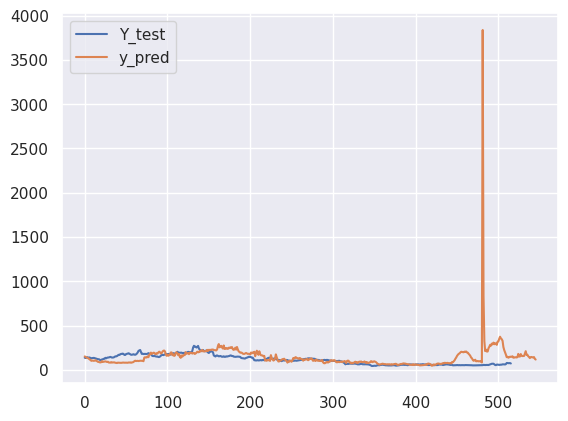

In [30]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [31]:
pre_df.to_csv("../result/ANN/ltc_NN.csv")

In [32]:

!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'